### Import Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Import Data

In [7]:
train = pd.read_csv('E:/BigFiles/MNIST/train.csv')

In [29]:
train.shape
# 784(28*28 pixels) + 1 label(class)

(42000, 785)

In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualize Digits

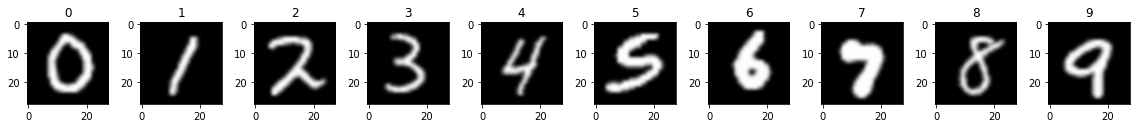

In [30]:
# Select one record(sample) for each label(0,1,2,3,4,5,6,7,8,9)
examples = [train[train.label == k].sample(1, random_state=42).values for k in range(10)]
fig,ax = plt.subplots(nrows =1,ncols=10,figsize=(20,1.5),squeeze=False)

for i,e in enumerate(examples):
    # reshape 1D to 2D array - a picture
    img = e[:, 1:].reshape(28,28).astype(float)
    # then draw it
    ax[0, i].set_title(i)
    ax[0, i].imshow(img, cmap='gray', interpolation='bicubic')

### Extract X, y from data

In [59]:
X,X_colnames,y = train.drop('label', axis=1).values,train.drop('label', axis=1).columns, train['label'].values

### Scaling

In [61]:
# Scale features to [0,1], some models are sensitive to non-scaled data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)

C:\Users\ankit.bhatia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [62]:
### Split training data to train & holdout
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X,y,test_size=0.15,random_state=42,
                                            stratify=train[train.columns[0]].values)

### Dimensionality Reduction

There are 784 features, it will be difficult and time consuming task to reduce the features using p-value and VIF score.
So let's use PCA to do that.

In [63]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

#### Let's plot the principal components and try to make sense of them
- We'll plot original features on the first 2 principal components as axes

In [66]:
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':X_colnames})
pcs_df.head()

,Feature,PC1,PC2
0,pixel0,-0.00,-0.00
1,pixel1,-0.00,-0.00
2,pixel2,-0.00,-0.00
3,pixel3,-0.00,0.00
4,pixel4,-0.00,0.00


In [71]:
train.drop('label', axis=1).head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Screeplot - plotting the cumulative variance against the number of components

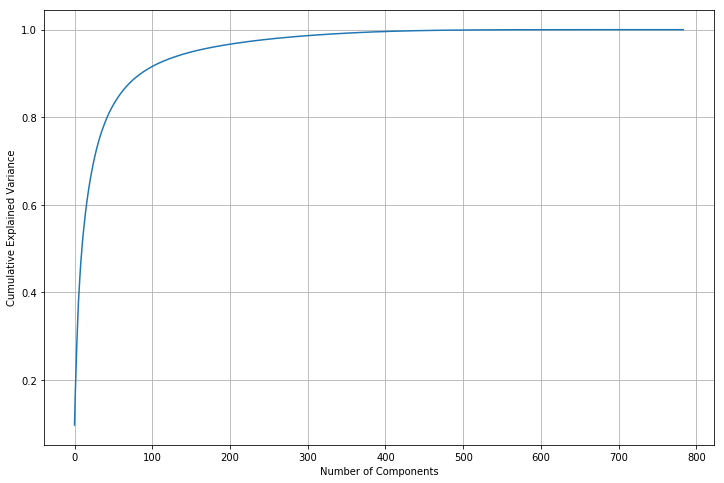

In [77]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

#### Looks like 50 components are enough to describe more than 80% of the variance in the dataset
- We'll choose 50 components for our modeling

Actual Dimensions 784, after PCA, 50

### Using incremental PCA for efficiency - saves a lot of time on larger datasets

In [78]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=50)
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(35700, 50)

#### Creating correlation matrix for the principal components - we expect little to no correlation

In [79]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

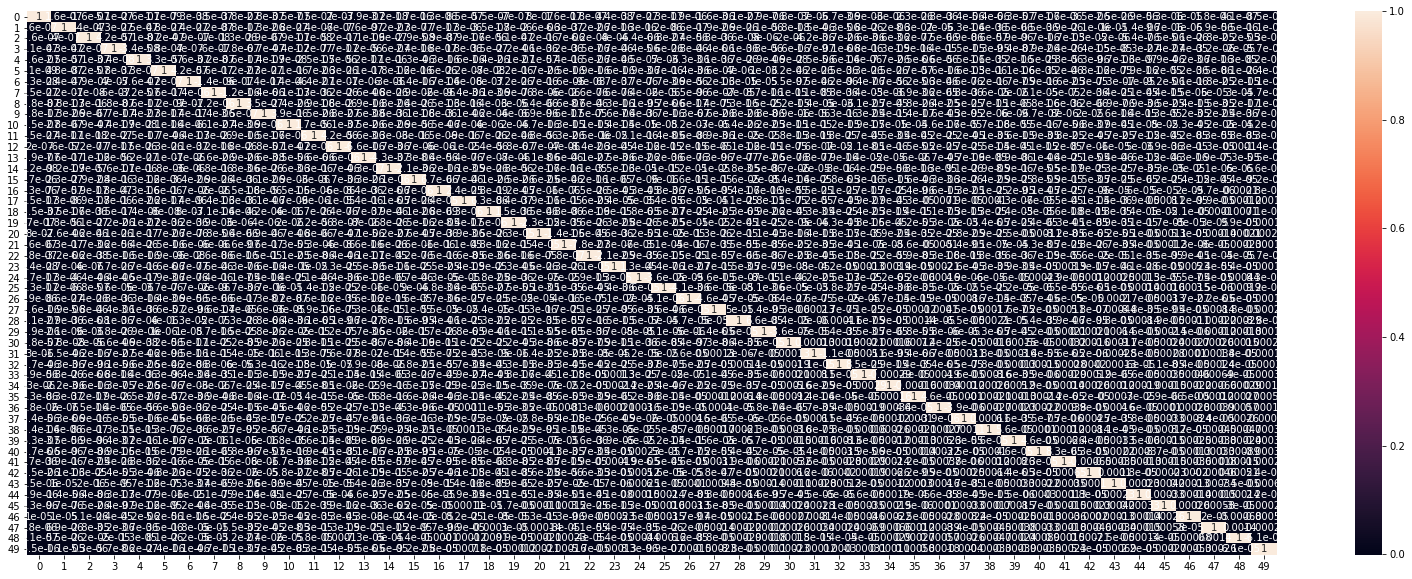

Execution Time:: 4.317112922668457


In [92]:
#plotting the correlation matrix
start_time = time.time()
plt.figure(figsize = (28,10))
sns.heatmap(corrmat,annot = True)
plt.show()
print('Execution Time::',time.time() - start_time)

In [82]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.00135563826906 , min corr:  -0.00068524346087


#### Indeed - there is no correlation between any two components! Good job, PCA!
- We effectively have removed multicollinearity from our situation, and our models will be much more stable

### SVM (Linear Model, without PCA)

In [96]:
from sklearn.svm import SVC
start_time = time.time()
model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_holdout)
print('Execution Time::',time.time() - start_time)

Execution Time:: 171.66963481903076


In [97]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_holdout, y_pred=y_pred))

accuracy: 0.929682539683


### SVM (Non Linear Model, without PCA, no hyperparameter tuning)

In [98]:
start_time = time.time()
non_linear_model = SVC(kernel='rbf')
# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_holdout)
print('Execution Time::',time.time() - start_time)

Execution Time:: 349.6599864959717


In [99]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_holdout, y_pred=y_pred))

accuracy: 0.931904761905


#### Grid Search: Hyperparameter Tuning

Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 5-fold cross validation.

In [ ]:
# creating a KFold object with 5 splits 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


### SVM (Non Linear Model, without PCA, hyperparameter tuning)

In [ ]:
start_time = time.time()
model = SVC(C=best_score, gamma=best_hyperparams, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_holdout)
print('Execution Time::',time.time() - start_time)

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_holdout, y_pred=y_pred))
